In [1]:
import pandas as pd
from langchain_community.llms import Ollama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import END, Graph
from typing import Dict, TypedDict, List
import json

In [2]:
import re

def load_excel_data(file_path: str) -> pd.DataFrame:
    """Load the Excel file and return a cleaned DataFrame."""
    # Load the data without assuming headers
    df = pd.read_excel(file_path, sheet_name='Sheet1', header=None)
    
    # Set the first row as column headers
    headers = df.iloc[0].tolist()
    
    # Handle duplicate columns by adding a suffix
    seen = {}
    new_headers = []
    for header in headers:
        if pd.isna(header):
            new_headers.append("unnamed")
            continue
        if header in seen:
            seen[header] += 1
            new_headers.append(f"{header}_{seen[header]}")
        else:
            seen[header] = 0
            new_headers.append(str(header))
    
    # Apply the new headers
    df.columns = new_headers
    df = df[1:]  # Remove the header row
    
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    # Convert date columns to consistent YYYY-MM format
    date_columns = [col for col in df.columns if isinstance(col, str) and re.match(r'^\d{4}-\d{2}-\d{2}', col)]
    for col in date_columns:
        try:
            # Convert to datetime and format as YYYY-MM
            df[col] = pd.to_datetime(df[col], errors='coerce').dt.strftime('%Y-%m')
            # Update column name to match new format
            new_col_name = pd.to_datetime(col).strftime('%Y-%m')
            if new_col_name in df.columns:
                # Handle potential duplicates after reformatting
                dup_count = sum(1 for c in df.columns if c.startswith(new_col_name))
                new_col_name = f"{new_col_name}_{dup_count}"
            df.rename(columns={col: new_col_name}, inplace=True)
        except:
            pass
    
    return df

In [3]:
# Initialize the LLM
llm = Ollama(model="llama3.1:8b")

C:\Users\R&D\AppData\Local\Temp\ipykernel_13164\1684553721.py:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3.1:8b")


In [4]:
# Define the agent state
class AgentState(TypedDict):
    question: str
    data: pd.DataFrame
    intermediate_steps: List[str]
    final_answer: str


In [5]:
# Define the tools (functions the agent can use)
def get_product_sales(state: AgentState) -> Dict:
    """Get sales data for a specific product."""
    question = state['question']
    data = state['data']
    
    # Simple extraction - look for product names in the question
    products = []
    for product in data['Product Name']:
        if product.lower() in question.lower():
            products.append(product)
    
    if not products:
        return {"result": "No matching products found in the data."}
    
    results = []
    for product in products:
        product_data = data[data['Product Name'] == product]
        if not product_data.empty:
            sales = product_data.iloc[:, 1:].to_dict(orient='records')[0]
            results.append({
                "product": product,
                "sales": sales
            })
    
    return {"result": results}

In [6]:
def get_top_products(state: AgentState) -> Dict:
    """Get top selling products."""
    data = state['data']
    
    # Calculate total sales for each product
    sales_columns = data.columns[1:]
    data['Total Sales'] = data[sales_columns].sum(axis=1)
    
    # Get top 5 products
    top_products = data.nlargest(5, 'Total Sales')[['Product Name', 'Total Sales']]
    
    return {"result": top_products.to_dict(orient='records')}


In [7]:
def get_monthly_sales(state: AgentState) -> Dict:
    """Get sales for a specific month."""
    question = state['question']
    data = state['data']
    
    # Find month in question
    months_in_data = data.columns[1:-1]  # Exclude 'Product Name' and potential 'Total Sales'
    found_month = None
    
    for month in months_in_data:
        if month in question:
            found_month = month
            break
    
    if not found_month:
        return {"result": "No specific month mentioned in the question."}
    
    monthly_sales = data[['Product Name', found_month]].sort_values(found_month, ascending=False)
    return {"result": monthly_sales.to_dict(orient='records')}


In [8]:
def router(state: AgentState) -> str:
    """Route to the appropriate tool based on the question."""
    question = state['question'].lower()
    data = state['data']
    
    # Get month names from column headers (formatted as YYYY-MM)
    month_columns = [col for col in data.columns if isinstance(col, str) and re.match(r'^\d{4}-\d{2}$', col)]
    
    # Check for product sales query
    if "product" in question and ("sales" in question or "sell" in question):
        return "get_product_sales"
    # Check for top products query
    elif "top" in question and ("product" in question or "selling" in question):
        return "get_top_products"
    # Check for monthly sales query
    elif "month" in question or any(month in question for month in month_columns):
        return "get_monthly_sales"
    else:
        return "general_query"

In [9]:
# Define the nodes for the graph
def general_query(state: AgentState) -> Dict:
    """Handle general queries that don't match specific tools."""
    prompt = ChatPromptTemplate.from_template("""
    You are an expert data analyst. Answer the user's question based on the provided sales data.
    
    Question: {question}
    
    Available data columns: {columns}
    
    Provide a helpful response. If you can't answer based on the data, say so.
    """)
    
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({
        "question": state['question'],
        "columns": list(state['data'].columns)
    })
    
    return {"result": response}


In [10]:
# Define the tool-calling function
def call_tool(state: AgentState) -> Dict:
    """Call the appropriate tool based on the router's decision."""
    tool_name = router(state)
    
    if tool_name == "get_product_sales":
        response = get_product_sales(state)
    elif tool_name == "get_top_products":
        response = get_top_products(state)
    elif tool_name == "get_monthly_sales":
        response = get_monthly_sales(state)
    else:
        response = general_query(state)
    
    return {"tool_response": response, "state": state}

In [11]:
def update_state(state: AgentState, tool_response: Dict) -> Dict:
    """Update the state with the tool's response."""
    state = state.copy()  # Create a copy to avoid modifying the original
    state["intermediate_steps"].append(tool_response["result"])
    return state

In [12]:
def generate_final_answer(state: AgentState) -> Dict:
    """Generate a final answer from the intermediate steps."""
    if len(state["intermediate_steps"]) == 0:
        return {"final_answer": "I couldn't find an answer to your question."}
    
    # For simplicity, just return the last step
    # In a more advanced version, you could summarize multiple steps
    final_answer = state["intermediate_steps"][-1]
    
    # Format the answer nicely if it's a dictionary
    if isinstance(final_answer, (list, dict)):
        try:
            final_answer = json.dumps(final_answer, indent=2)
        except:
            pass
    
    return {"final_answer": str(final_answer)}


In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

In [14]:
# Rebuild the workflow graph with proper connections
workflow = StateGraph(AgentState)

# Define nodes with correct inputs
workflow.add_node("call_tool", call_tool)
workflow.add_node("update_state", update_state)
workflow.add_node("generate_final_answer", generate_final_answer)

# Connect nodes with proper data flow
workflow.add_edge(START, "call_tool")
workflow.add_edge("call_tool", "update_state")
workflow.add_edge("update_state", "generate_final_answer")
workflow.add_edge("generate_final_answer", END)


# Compile the graph
app = workflow.compile()

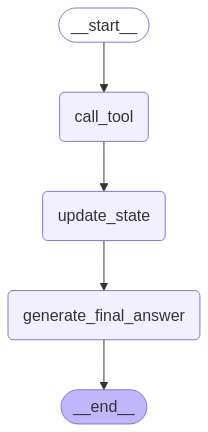

In [15]:
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
# Load your data
file_path = "Sales Report.xlsx"  # Update with your actual file path
data = load_excel_data(file_path)

In [19]:
app.invoke({
    "question": "What are the top selling products?",
    "data": data,
    "intermediate_steps": [],
    "final_answer": ""
})

TypeError: update_state() missing 1 required positional argument: 'tool_response'

In [17]:
def run_agent(question: str) -> str:
    """Run the agent with a given question."""
    initial_state = {
        "question": question,
        "data": data,
        "intermediate_steps": [],
        "final_answer": ""
    }
    
    try:
        # The graph now expects a dictionary with a "state" key
        result = app.invoke({"state": initial_state})
        return result["final_answer"]
    except Exception as e:
        return f"Error processing your request: {str(e)}"

In [18]:
# Test the agent
print(run_agent("What were the sales for 70mm Casement?"))
print("\n---\n")
print(run_agent("What were the top selling products?"))
print("\n---\n")
print(run_agent("How did sales look in 2021-07?"))

Error processing your request: 'question'

---

Error processing your request: 'question'

---

Error processing your request: 'question'
